In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device being used: ', DEVICE)

torch.backends.cudnn.deterministic = True


Device being used:  cuda:0


### Anomaly Array for Benchmarking

An index with anomalies would be great for benchmarking if our data was also by row indices, however it's by windows. We will not be creating a windowed anomaly labels as it becomes ambiguous how many anomalies might be present in regions where an anomaly occurs once every window length (ie. if window = 5, and an anomaly occurs every 5 rows then the entire index becomes anomalous).

Instead, we will try two things:

1. We will train an autoencoder on just rows.
2. We will train an autoencoder on windows then match the anomaly index to the window index to see if it was detected. This means that we ignore the 4 following windows since they may be detecting either the same or another anomaly ambiguously.


### Splitting Data

Since we want our model to learn what "normal" log events look like, we'll remove all original row indices labeled as anomalies. We can use the anom label index as our filter.

Training Data:
- First 8 million rows minus the anomalies (~ 7.7 million rows)

Unofficial Test Set:
- First 8 million rows with the anomalies

Test Set:
- 2 million rows (index 8mil to 10mil) with anomalies

Validation Set:
- Last 1-2 million rows, never before seen, with anomalies

In [121]:
# FOR TESTING WE ONLY IMPORT THE FIRST 100'000 ROWS
limit = 600000

## Import Anomaly Labels
anom = pd.read_csv('Data/anomaly_labels.csv', header=None, index_col=None, names=['anomaly'])[0:limit]
anom_idx = anom[anom.anomaly==1].index # anomaly index
normal_idx = anom[anom.anomaly==0].index # normal event index

anom = np.array(anom.anomaly) 
unofficial_test_key = anom[:400000]
official_test_key = anom[400000:500000]
validation_key = anom[500000:]

## Import Scaled Data
scaled = np.load('Data/ONEHOT_SCALED.npy')[0:limit]

### See if we can reduce dimensionality --> Yes

We will train and test both on a reduced and original dataframe to see if there's a difference.

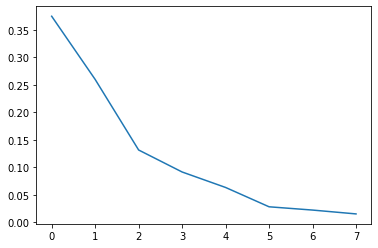

array([3.74442407e-01, 2.59742555e-01, 1.31593622e-01, 9.16514730e-02,
       6.35354417e-02, 2.84450951e-02, 2.24996402e-02, 1.55092849e-02,
       7.75151938e-03, 1.41001060e-03, 1.29544694e-03, 4.95385133e-04,
       4.25560874e-04, 3.05632251e-04, 2.45593193e-04, 2.15670925e-04,
       9.68049297e-05, 6.51079710e-05, 5.76354636e-05, 4.45650490e-05,
       3.11143077e-05, 2.97853181e-05, 2.16445934e-05, 1.24389351e-05,
       1.02427252e-05, 9.60806537e-06, 8.87263647e-06, 8.13570446e-06,
       6.97132161e-06, 5.52759663e-06, 4.86530011e-06, 4.65038152e-06])

In [125]:
## Reduce column dimensionality as the 128 columns are extremely sparse
visualize_pca = PCA().fit(scaled)

plt.plot(visualize_pca.explained_variance_ratio_[0:8])
plt.show()

visualize_pca.explained_variance_ratio_[0:32]

In [126]:
## Perform PCA with dimensionality reduction on first 32 principal components
pca = PCA(n_components=32)
scaled_pca = pca.fit_transform(scaled)

### A by ROW dataset on original data
These have the _og code at the end of labels

In [87]:
x_train_og = tf.convert_to_tensor(scaled[0:80000][normal_idx[normal_idx<80000]], dtype=np.float32) # train first 80'000 rows
print('Training after anomaly removal:', x_train_og.shape)
x_test_unofficial_anoms_og =  tf.convert_to_tensor(scaled[0:80000][anom_idx[anom_idx<80000]], dtype=np.float32)
print('x_test_unofficial_anoms:', x_test_unofficial_anoms_og.shape)
x_test_unofficial_og = tf.convert_to_tensor(scaled[0:80000], dtype=np.float32) # test on the same 80'000 rows
print('x_test_unofficial:', x_test_unofficial_og.shape)

print()

x_test_og = tf.convert_to_tensor(scaled[80000:96000], dtype=np.float32) # test on new 16'000 rows
print('x_test:', x_test_og.shape)
validation_og = tf.convert_to_tensor(scaled[96000:], dtype=np.float32) # validate on completely new 4'000 rows
print('validation:', validation_og.shape)

Training after anomaly removal: (77863, 128)
x_test_unofficial_anoms: (2137, 128)
x_test_unofficial: (80000, 128)

x_test: (16000, 128)
validation: (4000, 128)


### A by ROW dataset on a reduced dimension dataframe

In [5]:
x_train = tf.convert_to_tensor(scaled_pca[normal_idx[normal_idx<80000]], dtype=np.float32) # train on normal events in 80'000 rows
print('Training after anomaly removal:', x_train.shape)
x_test_unofficial_anoms =  tf.convert_to_tensor(scaled_pca[anom_idx[anom_idx<80000]], dtype=np.float32) # a validation set for training
print('x_test_unofficial_anoms:', x_test_unofficial_anoms.shape)
x_test_unofficial = tf.convert_to_tensor(scaled_pca[:80000], dtype=np.float32) # test on the same 80'000 rows with anomalies
print('x_test_unofficial:', x_test_unofficial.shape)

print()

x_test = tf.convert_to_tensor(scaled_pca[80000:96000], dtype=np.float32) # test on new 16'000 rows
print('x_test:', x_test.shape)
validation = tf.convert_to_tensor(scaled_pca[96000:], dtype=np.float32) # validate on completely new 4'000 rows
print('validation:', validation.shape)


Training after anomaly removal: (77863, 32)
x_test_unofficial_anoms: (2137, 32)
x_test_unofficial: (80000, 32)

x_test: (16000, 32)
validation: (4000, 32)


## Model Training (By Row)

We will train our autoencoder on normal events then use it to reconstruct the data. The hypothesis being, if the reconstruction error exceeds a certain threshold, we have detected an anomaly.

We define our model, using the Keras Model Subclassing API.



### Model for unreduced data

In [ ]:
# NON REDUCED DATA MODEL
class AnomalyDetector_og(Model):
  def __init__(self):
    super(AnomalyDetector_og, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(128, activation='sigmoid')])
      
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder_og = AnomalyDetector_og()
autoencoder_og.compile(optimizer='adam', loss='mae')

### Model for reduced data

In [88]:
# REDUCED DATA MODEL
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation='relu'),
      layers.Dense(32, activation='sigmoid')])
      
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')


In [89]:
## TRAINING
model_og = autoencoder_og.fit(x_train_og, x_train_og,
            epochs = 8,
            batch_size = 512,
            validation_data = (x_test_unofficial_anoms_og, x_test_unofficial_anoms_og),
            shuffle = True)

model_pca = autoencoder.fit(x_train, x_train,
            epochs = 8,
            batch_size = 512,
            validation_data = (x_test_unofficial_anoms, x_test_unofficial_anoms),
            shuffle = True)

Epoch 1/8
153/153 [==============================] - 4s 22ms/step - loss: 0.3643 - val_loss: 0.0265
Epoch 2/8
153/153 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0259
Epoch 3/8
153/153 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0258
Epoch 4/8
153/153 [==============================] - 3s 22ms/step - loss: 0.0255 - val_loss: 0.0254
Epoch 5/8
153/153 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0253
Epoch 6/8
153/153 [==============================] - 3s 22ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 7/8
153/153 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 8/8
153/153 [==============================] - 3s 22ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 1/8
153/153 [==============================] - 4s 22ms/step - loss: 0.4104 - val_loss: 0.0796
Epoch 2/8
153/153 [==============================] - 0s 3ms/step - loss: 0.0721 - val_loss: 0.0778
Epoch

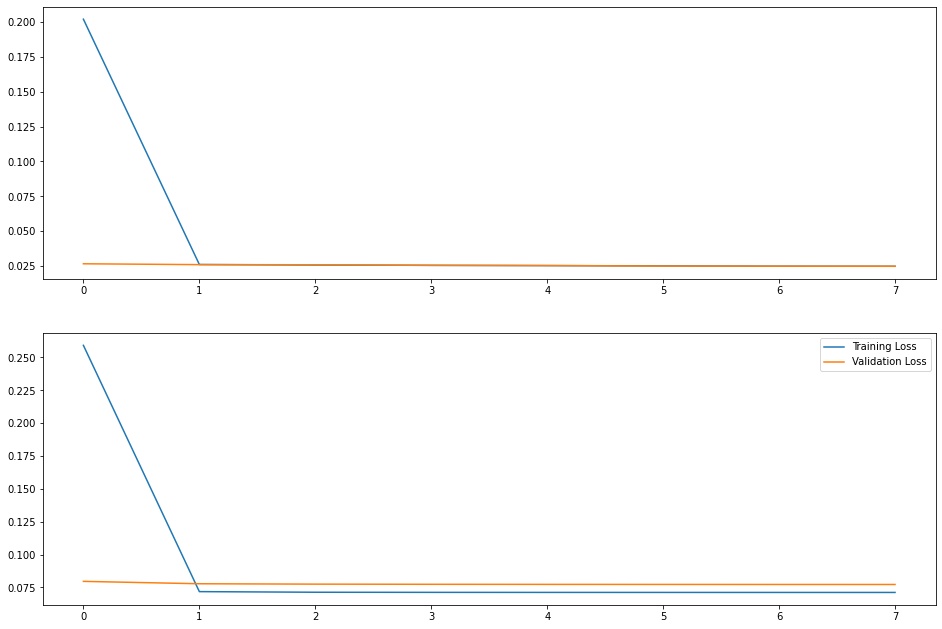

In [91]:
fig, axs = plt.subplots(2,1, figsize=(16,11))

axs[0].plot(model_og.history["loss"], label="Training Loss")
axs[0].plot(model_og.history["val_loss"], label="Validation Loss")
axs[1].plot(model_pca.history["loss"], label="Training Loss")
axs[1].plot(model_pca.history["val_loss"], label="Validation Loss")

plt.legend()

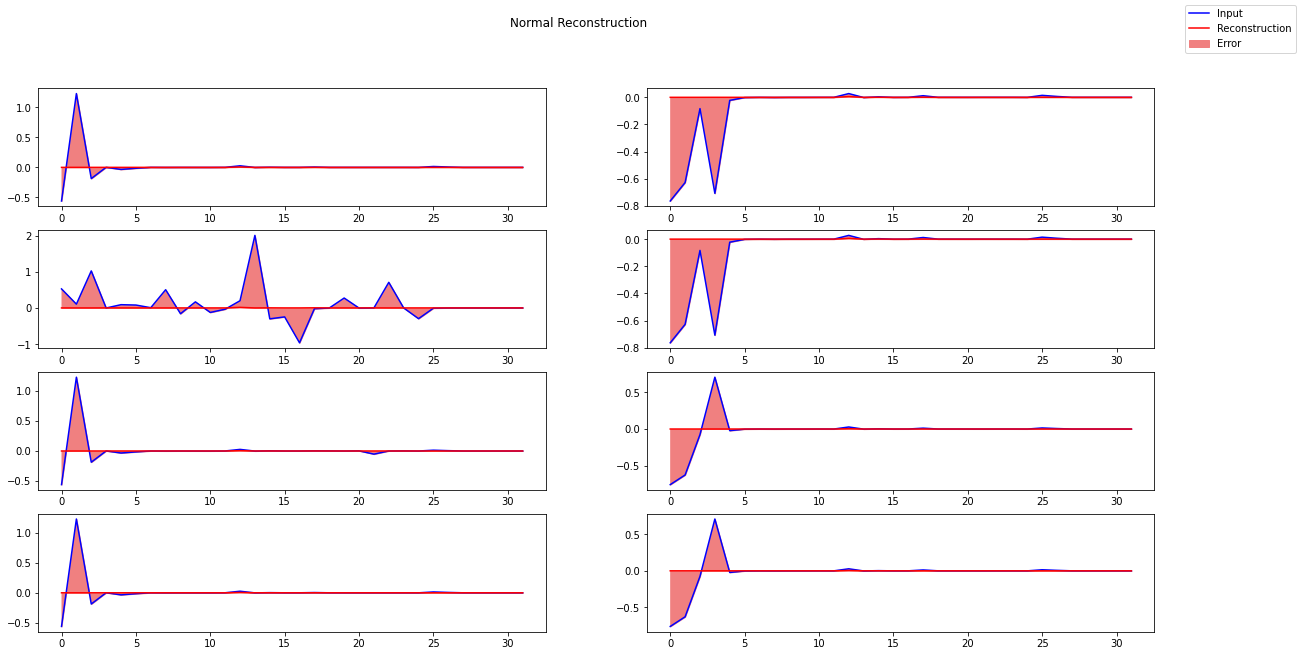

In [9]:
## RECONSTRUCTION FOR NORMAL EVENTS
encoded_logs_norm = autoencoder.encoder(x_train).numpy()
decoded_logs_norm = autoencoder.decoder(encoded_logs_norm).numpy()

fig, axs = plt.subplots(4,2, figsize=(20,10)) #subplot_kw=dict(projection='polar'),
fig.suptitle('Normal Reconstruction')

for row in range(4):
    for col in range(2):
        axs[row,col].plot(x_train[row+col*4], 'b')
        axs[row,col].plot(decoded_logs_norm[row+col*4], 'r')
        axs[row,col].fill_between(np.arange(32), decoded_logs_norm[row+col*4], x_train[row+col*4], color='lightcoral')

fig.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

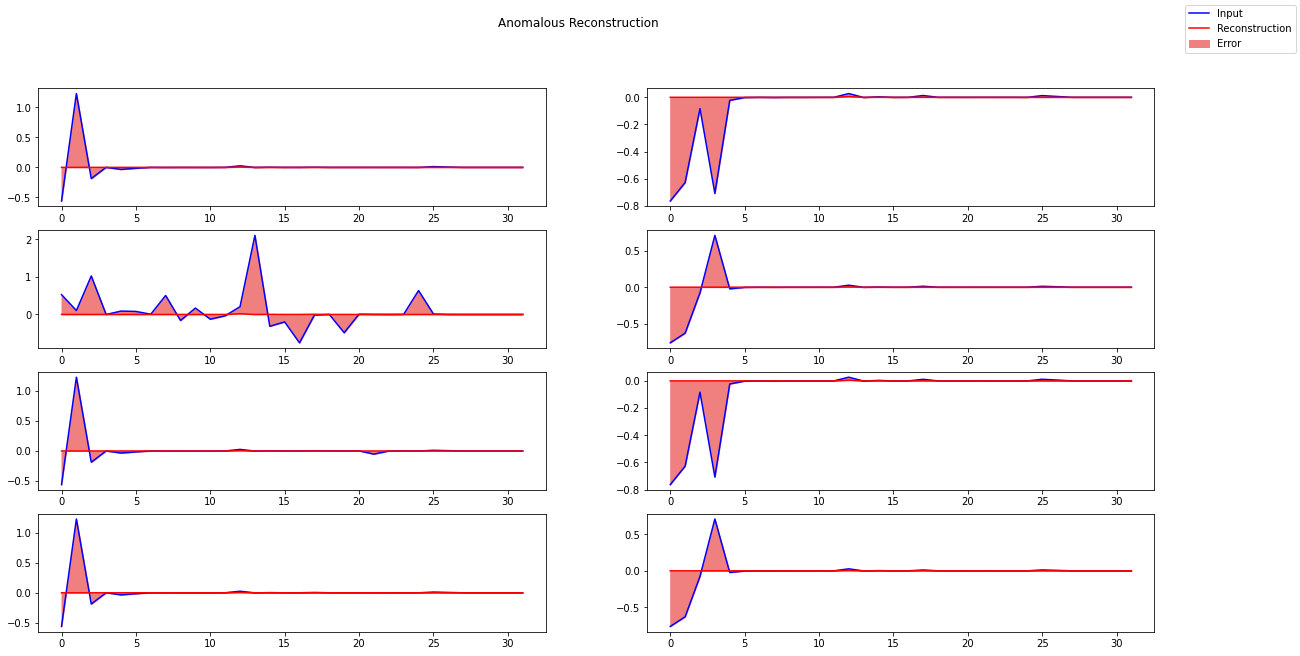

In [10]:
## RECONSTRUCTION FOR ANOMALOUS EVENTS
encoded_logs_anom = autoencoder.encoder(x_test_unofficial_anoms).numpy()
decoded_logs_anom = autoencoder.decoder(encoded_logs_anom).numpy()

fig, axs = plt.subplots(4,2, figsize=(20,10)) #subplot_kw=dict(projection='polar'),
fig.suptitle('Anomalous Reconstruction')

for row in range(4):
    for col in range(2):
        axs[row,col].plot(x_test_unofficial_anoms[row+col*4], 'b')
        axs[row,col].plot(decoded_logs_anom[row+col*4], 'r')
        axs[row,col].fill_between(np.arange(32), decoded_logs_anom[row+col*4], x_test_unofficial_anoms[row+col*4], color='lightcoral')

fig.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

## Model Evaluation

To evaluate models we'll first encode a set of data, decode it, then measure the loss between the original data and decoded data.

The losses will then be converted to binary to represent a prediction key of either normal or anomalous events. This will require a threshold for anomalies which we can compute using the mean and standard deviation of losses from the training set without anomalies.

Using the converted prediction key, we can directly compare it to the real anomaly key to get benchmarks. Our anomaly keys are:
- unofficial_test_key (original training window)
- official_test_key (new testing window)
- validation_key (never before seen testing window)

Let's start by getting our threshold hyperparameter:

1. Use x_train to create normal event reconstructions
2. Compute the losses
3. Get average and standard deviation of losses
4. Set threshold to be 2 std > mean loss


In [102]:
# Threshold function on original data
normal_reconstructions = autoencoder_og.predict(x_train_og)

train_loss = tf.keras.losses.mae(normal_reconstructions, x_train_og)

avg_train_loss = float(tf.math.reduce_mean(train_loss))
std_train_loss = float(tf.math.reduce_std(train_loss))

threshold_og = avg_train_loss + std_train_loss

print('Mean Loss :', avg_train_loss, '\nStd Loss :', std_train_loss, '\n\nThreshold for Anomalies (rounded) :', round(avg_train_loss+std_train_loss, 6))

## Define a function for converting the losses to binary
## Any loss > threshold = anomaly
loss_to_prediction_og = np.vectorize(lambda loss: 1 if (loss>threshold_og) else 0)

Mean Loss : 0.024723360314965248 
Std Loss : 0.013541272841393948 

Threshold for Anomalies (rounded) : 0.038265


In [94]:
# Threshold function on reduced data
normal_reconstructions = autoencoder.predict(x_train)

train_loss = tf.keras.losses.mae(normal_reconstructions, x_train)

avg_train_loss = float(tf.math.reduce_mean(train_loss))
std_train_loss = float(tf.math.reduce_std(train_loss))

threshold = avg_train_loss + std_train_loss

print('Mean Loss :', avg_train_loss, '\nStd Loss :', std_train_loss, '\n\nThreshold for Anomalies (rounded) :', round(avg_train_loss+std_train_loss, 6))

## Define a function for converting the losses to binary
## Any loss > threshold = anomaly
loss_to_prediction = np.vectorize(lambda loss: 1 if (loss>threshold) else 0)

Mean Loss : 0.07119156420230865 
Std Loss : 0.00648311385884881 

Threshold for Anomalies (rounded) : 0.077675


## Unofficial Benchmark

The unofficial benchmark uses the anomalies found in the same range as the training set. There are 2137 total anomalies.

We immediately see that PCA gives a huge improvement over training on original data. For PCA data these were the benchmarks:

- 90.7% of normal events were predicted as normal
- 9.3% of normal events were predicted as anomalies
- 76% of anomalies were predicted as normal **<-----------------------BAD**
- 24% of anomalies were predicted as anomalies


    Row 1 are true normal, Row 2 are true anomalies  
    Col 1 are predicted normal, Col 2 are predicted anomalies

Notes:
- *We are misclassifying 76% of anomalies as normal events*
- *Almost 93% of our anomaly predictions are actually normal events. This is very very bad*
- *Bear in mind we're only training on 100'000 events, there are over 10 million in the original data*


In [105]:
print('Unofficial test set anomalies :', len(anom_idx[anom_idx<80000]))

### ORIGINAL DATA
print('\nNON REDUCED DATA')
## Encode/Decode x_test_unofficial
test_reconstructions_og = autoencoder_og.predict(x_test_unofficial_og)
test_loss_og = tf.keras.losses.mae(test_reconstructions_og, x_test_unofficial_og).numpy()
## Convert test_loss to anomaly predictions
predictions_og =  loss_to_prediction_og(test_loss_og)
## Benchmarcks
print(confusion_matrix(unofficial_test_key, predictions_og), end = '\n\n')
print('Accuracy:', round(accuracy_score(unofficial_test_key, predictions_og), 4)) # of all predictions, how many were correct?
print('Precision:', round(precision_score(unofficial_test_key, predictions_og), 4)) # of predicted anomalies, how many were correct?
print('Recall:', round(recall_score(unofficial_test_key, predictions_og), 4)) # of all true anomalies, how many were recovered?


### PCA DATA
print('\n\nREDUCED DATA')
## Encode/Decode x_test_unofficial
test_reconstructions = autoencoder.predict(x_test_unofficial)
test_loss = tf.keras.losses.mae(test_reconstructions, x_test_unofficial).numpy()
## Convert test_loss to anomaly predictions
predictions =  loss_to_prediction(test_loss)
## Benchmarcks
print(confusion_matrix(unofficial_test_key, predictions), end = '\n\n')
print('Accuracy:', round(accuracy_score(unofficial_test_key, predictions), 4)) # of all predictions, how many were correct?
print('Precision:', round(precision_score(unofficial_test_key, predictions), 4)) # of predicted anomalies, how many were correct?
print('Recall:', round(recall_score(unofficial_test_key, predictions), 4)) # of all true anomalies, how many were recovered?


Unofficial test set anomalies : 2137
NON REDUCED DATA
[[54312 23551]
 [ 1503   634]]

Accuracy: 0.6868
Precision: 0.0262
Recall: 0.2967


REDUCED DATA
[[70627  7236]
 [ 1624   513]]

Accuracy: 0.8892
Precision: 0.0662
Recall: 0.2401


## Official Benchmark

The Official benchmark uses data not in the same range as the training set. There are 780 total anomalies.

    Row 1 are true normal, Row 2 are true anomalies
    Col 1 are predicted normal, Col 2 are predicted anomalies
    
Notes:
- *Almost 90% of our anomaly predictions are actually normal events. This is very very bad*


In [73]:
print('Official test set anomalies :', len(official_test_key[official_test_key==1]))

## Encode/Decode x_test_unofficial
test_reconstructions = autoencoder.predict(x_test)
test_loss = tf.keras.losses.mae(test_reconstructions, x_test).numpy()

## Convert test_loss to anomaly predictions
predictions =  loss_to_prediction(test_loss)

## Benchmarcks
print(confusion_matrix(official_test_key, predictions), end = '\n\n')
print('Accuracy:', round(accuracy_score(official_test_key, predictions), 4)) # of all predictions, how many were correct?
print('Precision:', round(precision_score(official_test_key, predictions), 4)) # of predicted anomalies, how many were correct?
print('Recall:', round(recall_score(official_test_key, predictions), 4)) # of all true anomalies, how many were recovered?

Official test set anomalies : 780
[[13848  1372]
 [  595   185]]

Accuracy: 0.8771
Precision: 0.1188
Recall: 0.2372


Our biggest issue is poor precision and recall. We miss a lot of anomalies and  classify a lot of normal events as anomalous.

How to fix this? We can try to train our model on event windows so time dependency is taken into account, although it would be more meaningful to model with time dependency within unique hadoop sessions. 

The issue with windows is how we benchmark and label anomaly predictions when there's a window of events to look at. We could try to "unwindow" the predictions by saying if a certain number of predictions were 1 in the next window of predictions, we count that as 1 anomaly. So if 3 anomalies are found in a window of 5 predictions, we will say 1 anomaly was detected.

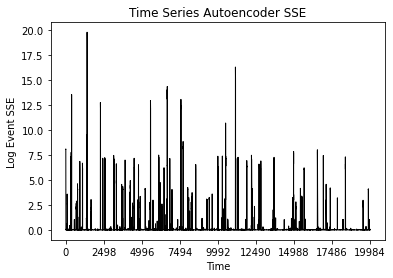

Std of event SSE :  1.2389477 
Mean of event SSE :  0.24913934 
4 std :  4.955790996551514


In [62]:
encoded_frames = autoencoder.encoder(x_test).numpy()
decoded_frames = autoencoder.decoder(encoded_frames).numpy()

sse_per_encoding = tf.math.reduce_sum(tf.math.square(x_test - decoded_frames), axis = [1,2])


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()
ax = plt.axes()
l, u = 0, 19990
stp = int((u-l)/8)

ax.plot(sse_per_encoding[l:u], c = 'black', lw = 1)
ax.set_yticks(np.arange(0,22,2.5))
ax.set_xticks(np.arange(0,u-l,stp))
ax.set_xlabel('Time')
ax.set_ylabel('Log Event SSE')
ax.set_title('Time Series Autoencoder SSE')
plt.show()

print('Std of event SSE : ', np.std(sse_per_encoding), '\nMean of event SSE : ', np.mean(sse_per_encoding), '\n4 std : ', 4*np.std(sse_per_encoding))

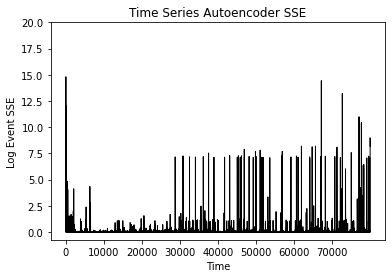

Std of event SSE :  0.6574213 
Mean of event SSE :  0.07831396 
4 std :  2.629685163497925


In [63]:
encoded_frames = autoencoder.encoder(x_train).numpy()
decoded_frames = autoencoder.decoder(encoded_frames).numpy()

sse_per_encoding = tf.math.reduce_sum(tf.math.square(x_train - decoded_frames), axis = [1,2])


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()
ax = plt.axes()
l, u = 0, 80000
stp = int((u-l)/8)

ax.plot(sse_per_encoding[l:u], c = 'black', lw = 1)
ax.set_yticks(np.arange(0,22,2.5))
ax.set_xticks(np.arange(0,u-l,stp))
ax.set_xlabel('Time')
ax.set_ylabel('Log Event SSE')
ax.set_title('Time Series Autoencoder SSE')
plt.show()

print('Std of event SSE : ', np.std(sse_per_encoding), '\nMean of event SSE : ', np.mean(sse_per_encoding), '\n4 std : ', 4*np.std(sse_per_encoding))